In [1]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.
import cv2
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.


In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
path = "data/Images"

In [5]:
data_label = pd.read_csv("total_label.csv")

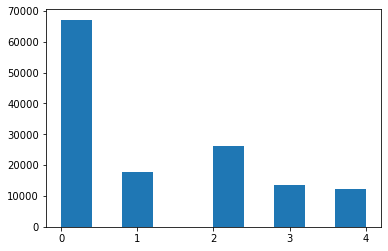

In [6]:
data_label.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [7]:
def sobel_filter(img):
# Apply the Sobel filter in the x direction
    sobel_x = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)

    # Apply the Sobel filter in the y direction
    sobel_y = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)

    # Combine the Sobel images using bitwise OR
    sobel = cv2.bitwise_or(sobel_x, sobel_y)
    return sobel

In [8]:
def load_ben_color(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [9]:
class dataset(Dataset): # Inherits from the Dataset class.

    def __init__(self,df,data_path,image_crop,image_filter,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        self.image_crop = image_crop
        self.image_filter = image_filter
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = cv2.imread(f'{self.data_path}/{image_id}.jpg') #Image.
        if self.image_transform :
            image = self.image_filter(image)
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            image = self.image_transform(image) #Applies transformation to the image.
            
        if self.train :
            label = self.df['level'][index] #Label.
        
            return image,torch.tensor(label) #If train == True, return image & label.

        
        else:
            return image #If train != True, return image.

In [10]:
data_validation_0 = data_label[data_label["validation"] == 0]

In [11]:
grouped = data_validation_0.groupby('level').count()
# Get the minimum count for any level number
min_count = grouped.min()[0]
# Sample 2000 rows for each level number
samples = []
for i in range(5):
    rows = data_validation_0[data_validation_0['level']==i].sample(n=min_count)
    samples.append(rows)
# Concatenate the samples into a single DataFrame
sampled_df = pd.concat(samples, ignore_index=True)
# Take a random sample of 10000 rows from the concatenated DataFrame
final_sample = sampled_df.sample(n=10000)

In [12]:
final_sample = final_sample.reset_index()

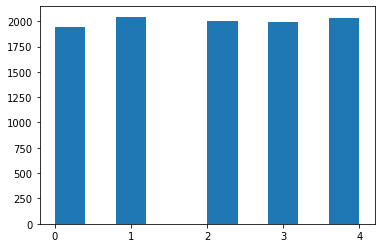

In [13]:
final_sample.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [14]:
my_transform = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
                                      
data_set = dataset(final_sample,f'{path}',image_transform = my_transform,image_crop=None,image_filter=load_ben_color)

print(len(data_set))
#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[9000,1000])

10000


In [15]:
train_dataloader = DataLoader(train_set,batch_size=8,shuffle=True) #DataLoader for train_set.
test_dataloader = DataLoader(valid_set,batch_size=8,shuffle=False) #DataLoader for validation

In [16]:
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
model = models.resnet152(pretrained=False)

# load the pre-trained weights
weights_url = 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'
state_dict = model_zoo.load_url(weights_url)
model.load_state_dict(state_dict)

c:\Users\PC\anaconda3\envs\machine_learn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\machine_learn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [17]:
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add a dropout layer to help prevent overfitting
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),  # Add batch normalization to help with training
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add another dropout layer
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 5)
)

In [18]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
def train(dataloader,model,loss_fn,optimizer):

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
     
        
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cuda().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cuda().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [20]:
def test(dataloader,model,loss_fn):

    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cuda().detach()
            correct      += (predictions == y.cuda().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [21]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = test(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [22]:

loss_fn   = nn.CrossEntropyLoss() #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.01) 
nb_epochs = 10
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,test_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/10
-------------------------------

Training Loss = 1.285072	Accuracy on Training set = 44.444444% [4000/9000]

Validation Loss = 1.089153	Accuracy on Validation set = 53.300000% [533/1000]

Epoch 2/10
-------------------------------

Training Loss = 1.141306	Accuracy on Training set = 52.722222% [4745/9000]

Validation Loss = 1.078481	Accuracy on Validation set = 54.400000% [544/1000]

Epoch 3/10
-------------------------------

Training Loss = 1.061987	Accuracy on Training set = 56.822222% [5114/9000]

Validation Loss = 1.053428	Accuracy on Validation set = 54.300000% [543/1000]

Epoch 4/10
-------------------------------

Training Loss = 0.962761	Accuracy on Training set = 60.800000% [5472/9000]

Validation Loss = 1.071588	Accuracy on Validation set = 55.200000% [552/1000]

Epoch 5/10
-------------------------------

Training Loss = 0.883589	Accuracy on Training set = 64.688889% [5822/9000]

Validation Loss = 1.131507	Accuracy on Validation set = 54.900000% [549/1000]

Epoc

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
df_validation = data_label[data_label["validation"] ==1]

In [25]:
df_validation = df_validation.reset_index()

In [26]:
path_for_validation = "data/validation_images"

valid_dataloader = dataset(df_validation,f'{path_for_validation}',image_transform = my_transform,image_crop=None,image_filter=load_ben_color)
data = DataLoader(valid_dataloader,batch_size = 32,shuffle=False)

In [27]:

# Set model to evaluation mode
model.eval()

# Create empty lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the validation set and make predictions
with torch.no_grad():
    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print(cm)

[[393   6  98   2   1]
 [122   3 254  98  23]
 [ 10   0 159 290  41]
 [204   5  80 157  54]
 [145   5  76 141 133]]


In [28]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)

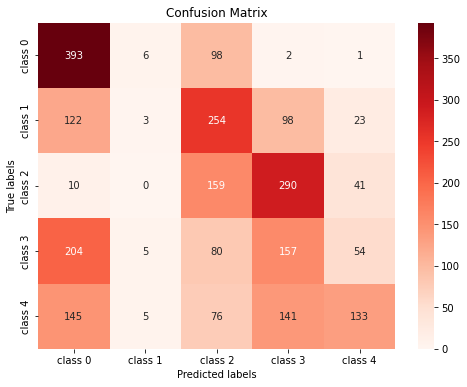

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# create the confusion matrix

# define the labels for the x-axis and y-axis
labels = ['class 0', 'class 1', 'class 2','class 3', 'class 4']

# create the heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))  # set the size of the figure
sns.heatmap(cm, cmap='Reds', annot=True, fmt='g', xticklabels=labels, yticklabels=labels, ax=ax)

# set the axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# show the plot
plt.show()

In [30]:
print(f"Accuracy of the model is {accuracy}")

Accuracy of the model is 0.338


Text(0.5, 1.0, 'Class: 0')

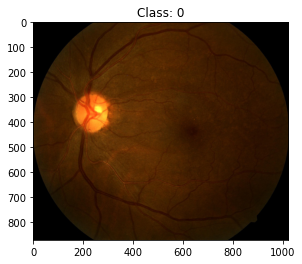

In [31]:
j =32

Imagee = Image.open(f'{path}/{data_label["image"][j]}.jpg')
plt.imshow(Imagee)
plt.title(f'Class: {data_label["level"][j]}')

In [32]:
Imagee = my_transform(Imagee)
Imagee = Imagee.to(device)
Imagee = Imagee.unsqueeze(0)
pred = model(Imagee)

probabilities = F.softmax(pred, dim=1)
probabilities

tensor([[1.0827e-04, 1.9945e-03, 7.7590e-03, 9.7070e-01, 1.9436e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)